# Outlier Function

This notebook creates the necessary functionalities for an outlier function to be integrated into the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/) package. The function will allow to choose between two clustering methods for outlier detection:

- DBSCAN
- K-means

In [1]:
# import the necessary packages
# Base packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import random

# Pyleoclim for integration
import pyleoclim as pyleo

# The magic 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Note that no new packages will be needed as requirements for Pyleoclim for this update. 

## Function creation

### Pyleoclim Utils

#### Tsutils

The following functions are low-level functionalities to perform the calculations and will be incoroporated in the tsutils module:

In [19]:
def calculate_distances(ys, n_neighbors=None, NN_kwargs=None):
    """
    
    Uses the scikit-learn unsupervised learner for implementing neighbor searches and calculate the distance between a point and its nearest neighbors to estimate epsilon for DBSCAN. 
    

    Parameters
    ----------
    ys : tnumpy.array
        the y-values for the timeseries
    n_neighbors : int, optional
        Number of neighbors to use by default for kneighbors queries. The default is None.
    NN_kwargs : dict, optional
        Other arguments for sklearn.neighbors.NearestNeighbors. The default is None.
        See: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

    Returns
    -------
    min_eps : int
        Minimum value for epsilon.
    max_eps : int
        Maximum value for epsilon.

    """
    
    ys=pyleo.utils.tsutils.standardize(ys)[0]
    ys=np.array(ys)
    
    if n_neighbors is None:
        # Lowest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        if min_eps<=0:
            min_eps=0.01
    
        # Highest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=len(ys)-1)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        max_eps = np.max(distances)
    
    else:
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        max_eps = np.max(distances)
    
    return min_eps, max_eps

def detect_outliers_DBSCAN(ys, nbr_clusters = None, eps=None, min_samples=None, n_neighbors=None, metric='euclidean', NN_kwargs= None, DBSCAN_kwargs=None):
    """
    Uses the unsupervised learning DBSCAN algorithm to identify outliers in timeseries data. 
    The algorithm uses the silhouette score calculated over a range of epsilon and minimum sample values to determine the best clustering. In this case, we take the largest silhouette score (as close to 1 as possible). 
    
    The DBSCAN implementation used here is from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
    
    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. For additional details, see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

    Parameters
    ----------
    ys : numpy.array
        The y-values for the timeseries data.
    nbr_clusters : int, optional
        Number of clusters. Note that the DBSCAN algorithm calculates the number of clusters automatically. This paramater affects the optimization over the silhouette score. The default is None.
    eps : float or list, optional
        epsilon. The default is None, which allows the algorithm to optimize for the best value of eps, using the silhouette score as the optimization criterion. The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
    min_samples : int or list, optional
        The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.. The default is None and optimized using the silhouette score
    n_neighbors : int, optional
        Number of neighbors to use by default for kneighbors queries, which can be used to calculate a range of plausible eps values. The default is None.
    metric : str, optional
        The metric to use when calculating distance between instances in a feature array. The default is 'euclidean'. See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html for alternative values. 
    NN_kwargs : dict, optional
        Other arguments for sklearn.neighbors.NearestNeighbors. The default is None.
        See: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

    DBSCAN_kwargs : dict, optional
        Other arguments for sklearn.cluster.DBSCAN. The default is None.
        See: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html


    Returns
    -------
    indices : list
        list of indices that are considered outliers.
    res : pandas.DataFrame
        Results of the clustering analysis. Contains information about eps value, min_samples value, number of clusters, the silhouette score, the indices of the outliers for each combination, and the cluster assignment for each point. 

    """
    
    
    NN_kwargs = {} if NN_kwargs is None else NN_kwargs.copy()
    DBSCAN_kwargs = {} if DBSCAN_kwargs is None else DBSCAN_kwargs.copy()
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    if eps is not None and n_neighbors is not None:
        print('Since eps is passed, ignoring the n_neighbors for distance calculation')
    
    if eps is None:
        min_eps,max_eps = calculate_distances(ys, n_neighbors=n_neighbors, NN_kwargs=NN_kwargs)       
        eps_list = np.linspace(min_eps,max_eps,50)
    elif type(eps) is list:
        eps_list=eps
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        eps_list=list(eps)
    
    if min_samples is None:
        min_samples_list = np.linspace(2,len(ys)/4,50,dtype='int')
    elif type(min_samples) is list:
        min_samples_list = min_samples
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        min_samples_list=list(min_samples)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    
    nbr_clusters=[]
    sil_score =[]
    eps_matrix=[]
    min_sample_matrix=[]
    idx_out = []
    clusters = []

    for eps_item in eps_list:
        for min_samples_item in min_samples_list:
            eps_matrix.append(eps_item)
            min_sample_matrix.append(min_samples_item)
            m = DBSCAN(eps=eps_item, min_samples=min_samples_item,**DBSCAN_kwargs)
            m.fit(ys.reshape(-1,1))
            nbr_clusters.append(len(np.unique(m.labels_))-1)
            try:
                sil_score.append(silhouette_score(ys.reshape(-1,1), m.labels_))
            except:
                sil_score.append(np.nan)
            idx_out.append(np.where(m.labels_==-1)[0])
            clusters.append(m.labels_)
            
    res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score,'outlier indices':idx_out,'clusters':clusters})
    
    if nbr_clusters is None: 
        res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
    else:
        try: 
            res_cl = res.loc[res['number of clusters']==nbr_clusters]
            res_sil = res_cl.loc[res_cl['silhouette score']==np.max(res_cl['silhouette score'])]
        except:
            print("No valid solutions for the number of clusters, returning from silhouette score")
            res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
    
    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def detect_outliers_kmeans(ys, nbr_clusters = None, max_cluster = 10, threshold=3, kmeans_kwargs=None):
    """
    Outlier detection using the unsupervised alogrithm kmeans. The algorithm runs through various number of clusters and optimizes based on the silhouette score.
    
    KMeans implementation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. For additional details, see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

    Parameters
    ----------
    ys : numpy.array
        The y-values for the timeseries data
    nbr_clusters : int or list, optional
        A user number of clusters to considered. The default is None.
    max_cluster : int, optional
        The maximum number of clusters to consider in the optimization based on the Silhouette Score. The default is 10.
    threshold : int, optional
        The algorithm uses the suclidean distance for each point in the cluster to identify the outliers. This parameter sets the threshold on the euclidean distance to define an outlier. The default is 3.
    kmeans_kwargs : dict, optional
        Other parameters for the kmeans function. See: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for details. The default is None.

    Returns
    -------
    indices : list
        list of indices that are considered outliers.
    res : pandas.DataFrame
        Results of the clustering analysis. Contains information about number of clusters, the silhouette score, the indices of the outliers for each combination, and the cluster assignment for each point. 


    """
    
    
    kmeans_kwargs = {} if kmeans_kwargs is None else kmeans_kwargs.copy()
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    # run with either one cluster number of several
    if nbr_clusters is not None:
        if type(nbr_clusters) == list:
            range_n_clusters = nbr_clusters
        else:
            range_n_clusters = [nbr_clusters]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    clusters = []
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1), **kmeans_kwargs)
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        distance=np.sqrt((ys-center)**2)
        idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
        clusters.append(kmeans.labels_)
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out,'clusters':clusters})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def remove_outliers(ts,ys,indices):
    """
    Remove the outliers from timeseries data

    Parameters
    ----------
    ts : numpy.array
        The time axis for the timeseries data.
    ys : numpy.array
        The y-values for the timeseries data.
    indices : numpy.array
        The indices of the outliers to be removed.

    Returns
    -------
    ys : numpy.array
        The time axis for the timeseries data after outliers removal
    ts : numpy.array
        The y-values for the timeseries data after outliers removal

    """
    ys = np.delete(ys,indices)
    ts = np.delete(ts,indices)

    return ys,ts

#### Plotting

We need to add a basic scatter plots functionalities to the plotting utils so we can set the same style as the rest of Pyleoclim. 

In [20]:
def scatter_xy(x,y,c=None, figsize=None, xlabel=None, ylabel=None, title=None, 
            xlim=None, ylim=None, savefig_settings=None, ax=None,
            legend=True, plot_kwargs=None, lgd_kwargs=None):
    """
    Make scatter plot. 

    Parameters
    ----------
    x : numpy.array
        x value
    y : numpy.array
        y value
    c : TYPE, optional
        DESCRIPTION. The default is None.
    figsize : list, optional
        A list of two integers indicating the dimension of the figure. The default is None.
    xlabel : str, optional
        x-axis label. The default is None.
    ylabel : str, optional
        y-axis label. The default is None.
    title : str, optional
        Title for the plot. The default is None.
    xlim : list, optional
        Limits for the x-axis. The default is None.
    ylim : list, optional
        Limits for the y-axis. The default is None.
    savefig_settings : dict, optional
        the dictionary of arguments for plt.savefig(); some notes below:
        - "path" must be specified; it can be any existed or non-existed path,
          with or without a suffix; if the suffix is not given in "path", it will follow "format"
        - "format" can be one of {"pdf", "eps", "png", "ps"}
       The default is None.
    ax : pyplot.axis, optional
        The axis object. The default is None.
    legend : bool, optional
        Whether to include a legend. The default is True.
    plot_kwargs : dict, optional
        the keyword arguments for ax.plot(). The default is None.
    lgd_kwargs : dict, optional
        the keyword arguments for ax.legend(). The default is None.

    Returns
    -------
    ax : the pyplot.axis object

    """
    savefig_settings = {} if savefig_settings is None else savefig_settings.copy()
    plot_kwargs = {} if plot_kwargs is None else plot_kwargs.copy()
    lgd_kwargs = {} if lgd_kwargs is None else lgd_kwargs.copy()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(x, y, c=c, **plot_kwargs)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if ylabel is not None:
        ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_ylim(ylim)

    if legend:
        ax.legend(**lgd_kwargs)
    else:
        ax.legend().remove()

    if 'fig' in locals():
        if 'path' in savefig_settings:
            savefig(fig, settings=savefig_settings)
        return fig, ax
    else:
        return ax

### Core: Series

The functions below shows the new functionalies for the Series class:

In [22]:
class Series(pyleo.Series):
    def outliers(self,method='kmeans',remove=True, settings=None, 
                 fig_outliers=True, figsize_outliers=[10,4], plotoutliers_kwargs=None, savefigoutliers_settings=None,
                 fig_clusters=True,figsize_clusters=[10,4], plotclusters_kwargs=None,savefigclusters_settings=None):
        """
        Remove outliers from timeseries data

        Parameters
        ----------
        method : str, {'kmeans','DBSCAN'}, optional
            The clustering method to use. The default is 'kmeans'.
        remove : bool, optional
            If True, removes the outliers. The default is True.
        settings : dict, optional
            Specific arguments for the clustering functions. The default is None.
        fig_outliers : bool, optional
            Whether to display the timeseries showing the outliers. The default is True.
        figsize_outliers : list, optional
            The dimensions of the outliers figure. The default is [10,4].
        plotoutliers_kwargs : dict, optional
            Arguments for the plot displaying the outliers. The default is None.
        savefigoutliers_settings : dict, optional
            Saving options for the outlier plot. The default is None.
            - "path" must be specified; it can be any existed or non-existed path,
              with or without a suffix; if the suffix is not given in "path", it will follow "format"
            - "format" can be one of {"pdf", "eps", "png", "ps"}
        fig_clusters : bool, optional
            Whether to display the clusters. The default is True.
        figsize_clusters : list, optional
            The dimensions of the cluster figures. The default is [10,4].
        plotclusters_kwargs : dict, optional
            Arguments for the cluster plot. The default is None.
        savefigclusters_settings : TYPE, optional
            Saving options for the cluster plot. The default is None.
            - "path" must be specified; it can be any existed or non-existed path,
              with or without a suffix; if the suffix is not given in "path", it will follow "format"
            - "format" can be one of {"pdf", "eps", "png", "ps"}

        Returns
        -------
        ts: pyleoclim.Series
            A new Series object witthout outliers if remove is True. Otherwise, returns the original timeseries
        
        res: pandas.DataFrame
            Contains relevant diagnostic metrics for the clustering algorithms. 

        """    
        if method not in ['kmeans','DBSCAN']:
            raise ValueError('method should either be "kmeans" or "DBSCAN"')
        
        # run the algorithm
        settings = {} if settings is None else settings.copy()
        spec_func={
            'kmeans':detect_outliers_kmeans,
            'DBSCAN':detect_outliers_DBSCAN}
        args = {}
        args['kmeans'] = {}
        args['DBSCAN'] = {}
        args[method].update(settings)
        
        indices, res = spec_func[method](self.value,**args[method])
        
        # Create the new Series object
        new=self.copy()        
        if remove==True:
            ts,ys=remove_outliers(self.time,self.value,indices)
            new.value=ys
            new.time=ts
        
        # Figures
        # Optional parameters
        savefigoutliers_settings = {} if savefigoutliers_settings is None else savefigoutliers_settings.copy()
        savefigclusters_settings = {} if savefigclusters_settings is None else savefigclusters_settings.copy()
        plotoutliers_kwargs = {} if plotoutliers_kwargs is None else plotoutliers_kwargs.copy()
        plotclusters_kwargs = {} if plotclusters_kwargs is None else plotclusters_kwargs.copy()
        
        # Figure showing the outliers
        
        if fig_outliers == True:
            fig,ax = plt.subplots(figsize=figsize_outliers)
            time_label, value_label = self.make_labels()
                
            if 'xlabel' not in plotoutliers_kwargs.keys():
                xlabel = time_label
            else:
                xlabel = plotoutliers_kwargs['xlabel']
                plotoutliers_kwargs.pop('xlabel')
            
            if 'ylabel' not in plotoutliers_kwargs.keys():
                ylabel = value_label
            else:
                ylabel = plotoutliers_kwargs['ylabel']
                plotoutliers_kwargs.pop('ylabel')
            
            if 'title' not in plotoutliers_kwargs.keys():
                title = None
            else:
                title = plotoutliers_kwargs['title']
                plotoutliers_kwargs.pop('title')
            
            if 'xlim' not in plotoutliers_kwargs.keys():
                xlim = None
            else:
                xlim = plotoutliers_kwargs['xlim']
                plotoutliers_kwargs.pop('xlim')
            
            if 'ylim' not in plotoutliers_kwargs.keys():
                ylim = None
            else:
                ylim = plotoutliers_kwargs['ylim']
                plotoutliers_kwargs.pop('ylim')
            
            if 'legend' not in plotoutliers_kwargs.keys():
                legend = True
            else:
                legend = plotoutliers_kwargs['legend']
                plotoutliers_kwargs.pop('legend')
            
            pyleo.utils.plotting.plot_scatter_xy(self.time,self.value,self.time[indices],self.value[indices],
                                                 xlabel=xlabel,ylabel=ylabel,
                                                 title =  title, xlim=xlim, ylim=ylim, legend=legend, 
                                                 plot_kwargs=plotoutliers_kwargs,ax=ax)
            
            #Saving options
            if 'path' in savefigoutliers_settings:
                pyleo.utils.plotting.savefig(fig,settings=savefigoutliers_settings)
        
        if fig_clusters == True:
            fig,ax = plt.subplots(figsize=figsize_clusters)
            
            # dealt with plot options
            time_label, value_label = self.make_labels()
                
            if 'xlabel' not in plotclusters_kwargs.keys():
                xlabel = time_label
            else:
                xlabel = plotclusters_kwargs['xlabel']
                plotoclusters_kwargs.pop('xlabel')
            
            if 'ylabel' not in plotclusters_kwargs.keys():
                ylabel = value_label
            else:
                ylabel = plotclusters_kwargs['ylabel']
                plotclusters_kwargs.pop('ylabel')
            
            if 'title' not in plotclusters_kwargs.keys():
                title = None
            else:
                title = plotclusters_kwargs['title']
                plotclusters_kwargs.pop('title')
            
            if 'xlim' not in plotclusters_kwargs.keys():
                xlim = None
            else:
                xlim = plotclusters_kwargs['xlim']
                plotclusters_kwargs.pop('xlim')
            
            if 'ylim' not in plotclusters_kwargs.keys():
                ylim = None
            else:
                ylim = plotclusters_kwargs['ylim']
                plotclusters_kwargs.pop('ylim')
            
            if 'legend' not in plotclusters_kwargs.keys():
                legend = True
            else:
                legend = plotclusters_kwargs['legend']
                plotclusters_kwargs.pop('legend')
            
            clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
            
            if 'c' not in plotclusters_kwargs.keys():
                color_list = list(mcolors.CSS4_COLORS.keys())
                color_list.remove('red')
                random.Random(9).shuffle(color_list)
                colors = color_list[0:len(np.unique(clusters))] 
                vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
                c = vectorizer(clusters)
            else:
                c = plotclusters_kwargs['c']
                plotclusters_kwargs.pop('c')
            
            scatter_xy(self.time,self.value,c = c, xlabel=xlabel,ylabel=ylabel,
                       title =  title, xlim=xlim, ylim=ylim, legend=legend,  
                       plot_kwargs = plotclusters_kwargs, ax=ax)
                
            #plot     
            if np.size(indices) != 0:
                scatter_xy(self.time[indices],self.value[indices],c='red',ax=ax)
            if 'path' in savefigclusters_settings:
                pyleo.utils.plotting.savefig(fig,settings=savefigclusters_settings)
        
        return new, res  

## Example uses:

This can be used for pytest functions. 

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

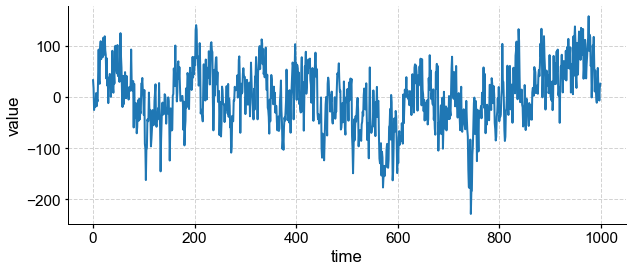

In [5]:
t,v = pyleo.utils.gen_ts(model='colored_noise',nt=1000,seed=1983)
ts=Series(time=t,value=v)
ts.plot()

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

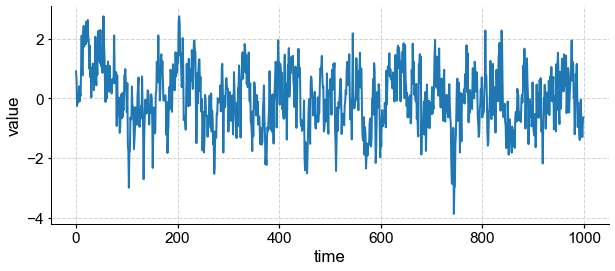

In [6]:
ts_new=ts.detrend(method='emd',n=3).standardize()
ts_new.plot()

All default parameters:

Optimizing for the best number of clusters, this may take a few minutes


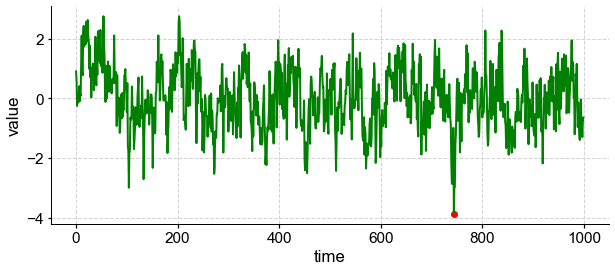

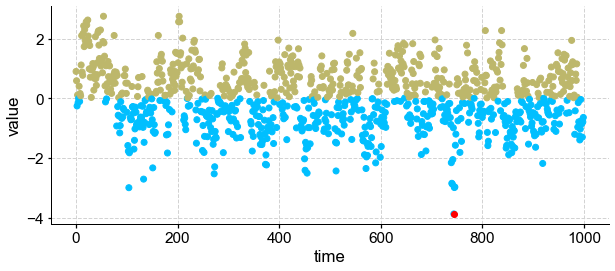

In [8]:
ts_out, res =ts_new.outliers()

Use DBSCAN instead of kmeans:

Optimizing for the best number of clusters, this may take a few minutes


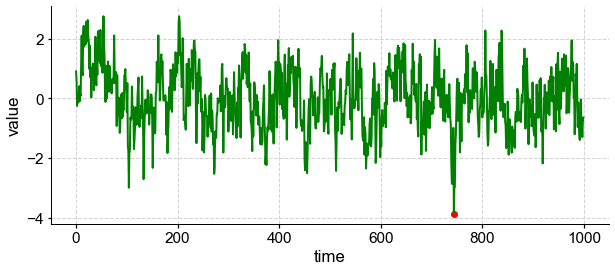

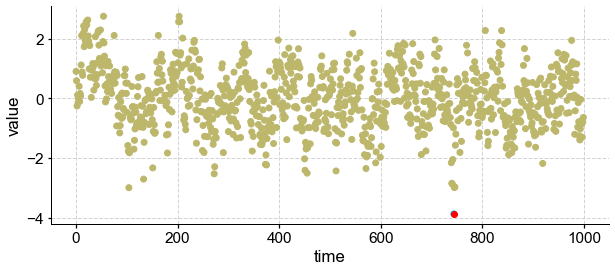

In [9]:
ts_out, res =ts_new.outliers(method='DBSCAN')

Change parameters for the function using settings. The most useful may be the number of clusters:

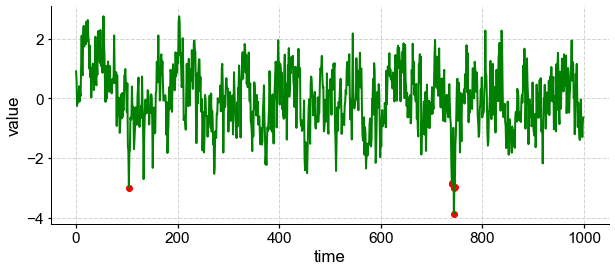

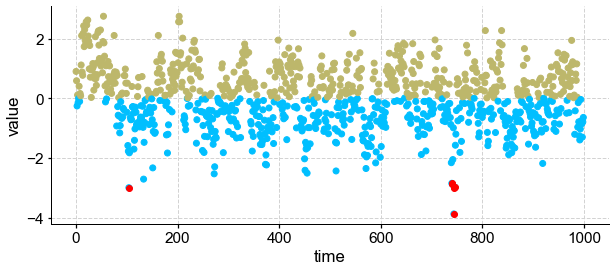

In [17]:
ts_out, res =ts_new.outliers(settings={'nbr_clusters':2, 'threshold':2})

Optimizing for the best number of clusters, this may take a few minutes


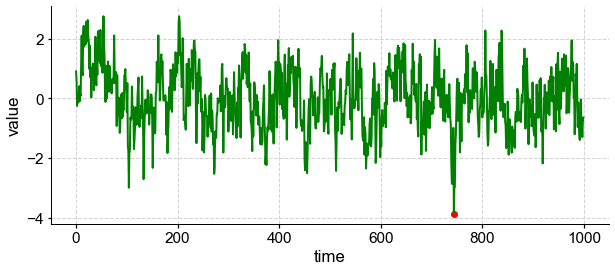

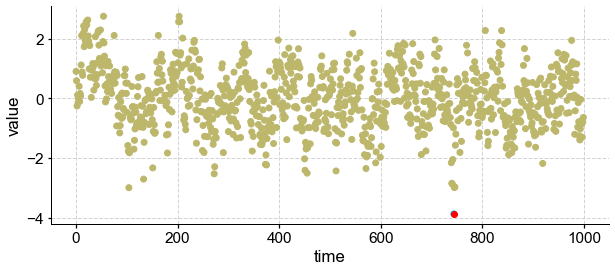

In [18]:
ts_out, res =ts_new.outliers(method='DBSCAN',settings={'nbr_clusters':1})

## Paleoclimate test cases

Paleoclimate test cases for this new functionality can be found in the notebooks dedicated to each of the method in this repository, namely `Kmeans.ipynd` and `DBSCAN.ipynb`.